In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from IPython.display import display

pd.set_option("display.max_columns", 40)
pd.set_option('display.max_rows', 10000)

In [2]:
def fetch_files(path, pattern, header=None):
    all_files = glob.glob(path + "/" + pattern)
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=header)
        df["filename"] = filename
        li.append(df)
        
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

def format_chart(title: str, x_label: str, y_label: str, xticks_range: range, figsize=(15, 8), divider=1000000, sufix="M"):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    xticks_range = xticks_range
    plt.xticks(xticks_range, [str(round(x/divider, 1)) + sufix for x in xticks_range])
    plt.title(title)
    return ax

In [3]:
root_dir = "C:/Users/micha/Desktop/SIMM/output/2iteration"
parquet_to_S3 = fetch_files(root_dir, "parquet_toS3_timing_*", header=0)
parquet_read = fetch_files(root_dir, "parquet_read_timing_*", header=0)
athena_query = fetch_files(root_dir, "athena_query_timing_*", header=0)

In [4]:
parquet_to_S3["duration"] = pd.to_timedelta(parquet_to_S3["duration"]).dt.total_seconds()
parquet_read["duration"] = pd.to_timedelta(parquet_read["duration"]).dt.total_seconds()
athena_query["duration"] = pd.to_timedelta(athena_query["duration"]).dt.total_seconds()

In [5]:
stats = pd.concat([parquet_to_S3.groupby(["Dataset", "dataset_sufix"]).agg({"compression": "first", "partition_cols": "first", "load_id": [pd.Series.nunique, "max"]}),
                   parquet_read.groupby(["Dataset", "dataset_sufix"]).agg({"rows": "min"})],
                  axis=1)
stats[("load_id", "max")] = (stats[("load_id", "nunique")] / (round(stats[("load_id", "max")], -3) / 10000 + 1)).astype("int")
stats[("load_id", "nunique")] = (stats[("load_id", "nunique")] / stats[("load_id", "max")]).astype("int")
stats

(compression, first)  \
Dataset                dataset_sufix                        
simm_risk_data_eqderiv 20200722t1212               snappy   
                       20200722t1548               snappy   
                       20200722t1731               snappy   
                       20200723t1858               snappy   
                       20200723t2010               snappy   
                       20200723t2257                 gzip   
                       20200723t2307                 gzip   

                                          (partition_cols, first)  \
Dataset                dataset_sufix                                
simm_risk_data_eqderiv 20200722t1212                ['tabledate']   
                       20200722t1548  ['tabledate', 'atomicload']   
                       20200722t1731  ['tabledate', 'atomicload']   
                       20200723t1858                ['tabledate']   
                       20200723t2010  ['tabledate', 'atomicload']   
                       20200723t2257                ['tabledate']   
                       20200723t2307  ['tabledate', 'atomicload']   

                                      (load_id, nunique)  (load_id, max)  \
Dataset                dataset_sufix                                       
simm_risk_data_eqderiv 20200722t1212                   7               1   
                       20200722t1548                   4            1507   
                       20200722t1731                   7             184   
                       20200723t1858                  32               1   
                       20200723t2010                  32            1560   
                       20200723t2257                   5               1   
                       20200723t2307                   5            1509   

                                          rows  
Dataset                dataset_sufix            
simm_risk_data_eqderiv 20200722t1212  10430837  
                       20200722t1548  10430837  
                       20200722t1731   3358100  
                       20200723t1858   1043083  
                       20200723t2010   1230837  
                       20200723t2257   1043083  
                       20200723t2307   1230837

In [6]:
translator = {}
for index, row in stats.iterrows():
    translator[index[1]] = row[("compression", "first")] + ";" + row[("partition_cols", "first")] + ";" + str(row[("load_id", "max")]) + ";" + str(row["rows"])

In [7]:
stats = stats.reset_index()
stats["dataset_sufix"] = stats.apply(lambda x: translator[x["dataset_sufix"]], axis=1)
stats.set_index(["Dataset", "dataset_sufix"], inplace=True)

In [8]:
parquet_to_S3["original_sufix"] = parquet_to_S3["dataset_sufix"]
parquet_read["original_sufix"] = parquet_read["dataset_sufix"]
athena_query["original_sufix"] = athena_query["dataset_sufix"]
parquet_to_S3["dataset_sufix"] = parquet_to_S3.apply(lambda x: translator[x["dataset_sufix"]], axis=1)
parquet_read["dataset_sufix"] = parquet_read.apply(lambda x: translator[x["dataset_sufix"]], axis=1)
athena_query["dataset_sufix"] = athena_query.apply(lambda x: translator[x["dataset_sufix"]], axis=1)

In [9]:
# List of timing for Dataset size = 10M. Please note one outlier
parquet_to_S3[parquet_to_S3["Dataset size"]==10430837]

,Unnamed: 0,Dataset,dataset_sufix,use_dict_encoding,compression,partition_cols,load_id,Dataset size,duration,filename,original_sufix
0,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],0,10430837,207.673984,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212
1,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],10000,10430837,218.579776,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212
2,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],20000,10430837,198.275992,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212
3,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],30000,10430837,206.304241,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212
4,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],40000,10430837,293.761883,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212
5,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],50000,10430837,825.009593,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212
6,0,simm_risk_data_eqderiv,snappy;['tabledate'];1;10430837,True,snappy,['tabledate'],60000,10430837,289.410989,C:/Users/micha/Desktop/SIMM/output/2iteration\...,20200722t1212


In [10]:
# Filtering out one outlier
parquet_to_S3 = parquet_to_S3[parquet_to_S3["duration"]<825]

In [11]:
load_group = parquet_to_S3.groupby(["Dataset size"]).agg({"duration": ["mean", "std", "min", "max"]})
load_group

duration                                   
                    mean        std         min         max
Dataset size                                               
1               1.120601   1.209045    0.503031   15.724347
2               1.095045   1.139453    0.508570   11.943002
3               1.148613   1.144358    0.502185    8.869243
4               1.176404   1.183946    0.508183    8.965117
5               1.095391   1.181992    0.519418   10.592800
6               1.141742   1.596510    0.508047   31.824891
7               1.112990   1.138568    0.508350    9.427332
8               1.149703   1.607167    0.503410   35.040329
9               1.146924   1.280419    0.511699   15.917107
10              1.124661   1.140774    0.515505   11.356892
11              0.969353   1.189527    0.511136   17.804742
12              1.105158   1.143293    0.512996    9.114360
13              1.050995   1.064790    0.513553    9.686643
14              1.049567   1.178635    0.511157   16.523197
15              1.248753   1.434004    0.504858   17.929705
16              1.168878   1.257305    0.514294   10.972207
17              1.200304   1.221778    0.510221    7.954422
18              1.137601   1.153890    0.517512   10.120724
19              1.054581   0.966454    0.508153    6.880705
20              1.153714   1.148444    0.517497    8.719405
21              1.171397   1.213217    0.517237   13.404238
22              1.221765   1.234333    0.507079   10.982065
23              1.104839   1.115730    0.518112    9.142665
24              1.105993   1.063146    0.512940    9.014640
25              1.260991   1.650137    0.514127   32.009511
26              1.147895   1.183565    0.511238    7.989340
27              1.082880   1.087955    0.513924    8.370369
28              1.131987   1.149501    0.514465    8.222113
29              1.127288   1.172906    0.519418   10.500282
30              1.027453   1.052908    0.512380   11.051563
31              1.048944   1.030919    0.508178    8.104483
32              1.063434   1.289613    0.510797   16.913101
33              0.982283   1.032994    0.510659   10.121803
34              1.112026   1.201095    0.506747   11.625927
35              1.296577   1.506499    0.512951   17.654285
36              1.086963   1.124687    0.519275   10.004576
37              1.182082   1.222666    0.513678   14.553892
38              1.059110   1.069295    0.510457    8.510570
39              1.159512   1.149117    0.506341    6.849774
40              1.234788   1.278136    0.510397    8.611906
41              1.318013   1.261173    0.513059    7.530619
42              1.217069   1.258670    0.513732   11.095923
43              1.130476   1.157706    0.513855    7.505414
44              1.125123   1.142289    0.506073    7.804245
45              1.068223   1.024565    0.516675    7.300054
46              1.031493   1.076884    0.514716   10.554431
47              1.215044   1.147256    0.521934    6.935155
48              1.198749   1.398769    0.519938   18.542514
49              1.044114   1.041003    0.513136    6.649268
50              0.971476   1.030173    0.519009    8.649599
51              1.237725   1.224802    0.514959    9.684755
52              1.178387   1.200480    0.516948    6.382327
53              1.205314   1.293886    0.516617    8.824512
54              1.009995   0.914548    0.512076    6.537000
55              1.058573   1.038968    0.517606    7.264028
56              1.130635   1.158953    0.525189    7.158856
57              1.043949   1.033952    0.510370    6.607251
58              1.125133   1.139107    0.510677    7.823882
59              1.179793   1.353367    0.507655   12.265282
60              1.228981   1.247347    0.520258    9.534293
61              1.128435   1.247687    0.519344    9.909349
62              1.128240   1.216879    0.520928   10.478791
63              1.154989   1.145839    0.509141    8.562178
64              1.117174   1.195922    0.509402    9.448

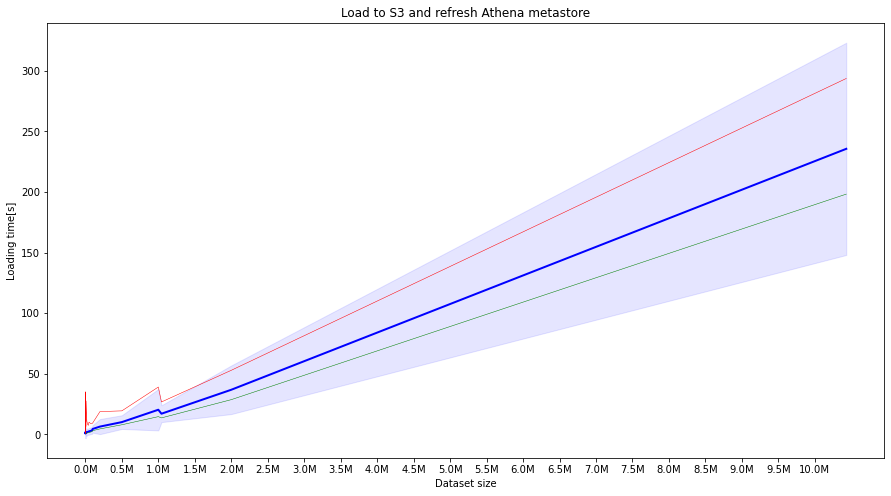

In [12]:
format_chart(title="Load to S3 and refresh Athena metastore",
             x_label="Dataset size", 
             y_label="Loading time[s]", 
             xticks_range=range(0, 10_000_001, 500_000))

plt.plot(load_group[("duration", "mean")], linewidth=2, color="b")
plt.plot(load_group[("duration", "min")], linewidth=.5, color="g")
plt.plot(load_group[("duration", "max")], linewidth=.5, color="r")
plt.fill_between(load_group.index, 
                 load_group[("duration", "mean")] - 2*load_group[("duration", "std")],
                 load_group[("duration", "mean")] + 2*load_group[("duration", "std")],
                 color="b", alpha=.1)

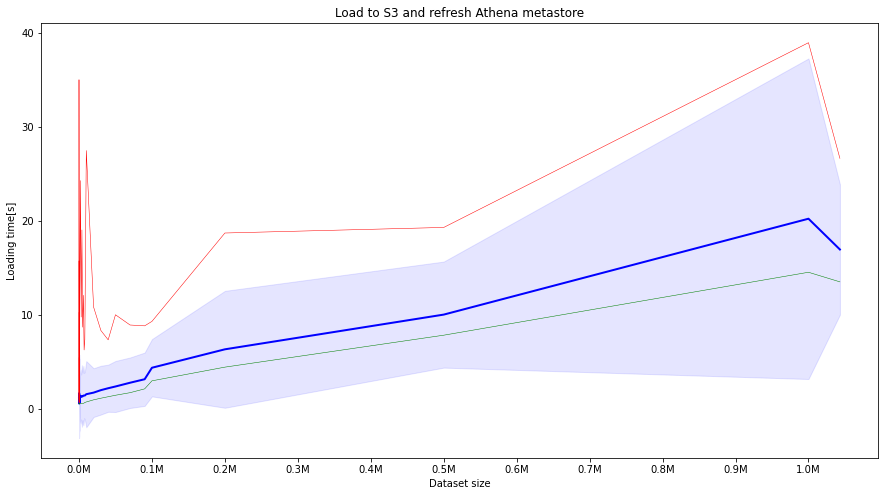

In [13]:
load_group = load_group.loc[:1200000]

format_chart(title="Load to S3 and refresh Athena metastore",
             x_label="Dataset size", 
             y_label="Loading time[s]", 
             xticks_range=range(0, 1_000_001, 100_000))

plt.plot(load_group[("duration", "mean")], linewidth=2, color="b")
plt.plot(load_group[("duration", "min")], linewidth=.5, color="g")
plt.plot(load_group[("duration", "max")], linewidth=.5, color="r")
plt.fill_between(load_group.index, 
                 load_group[("duration", "mean")] - 2*load_group[("duration", "std")],
                 load_group[("duration", "mean")] + 2*load_group[("duration", "std")],
                 color="b", alpha=.1)

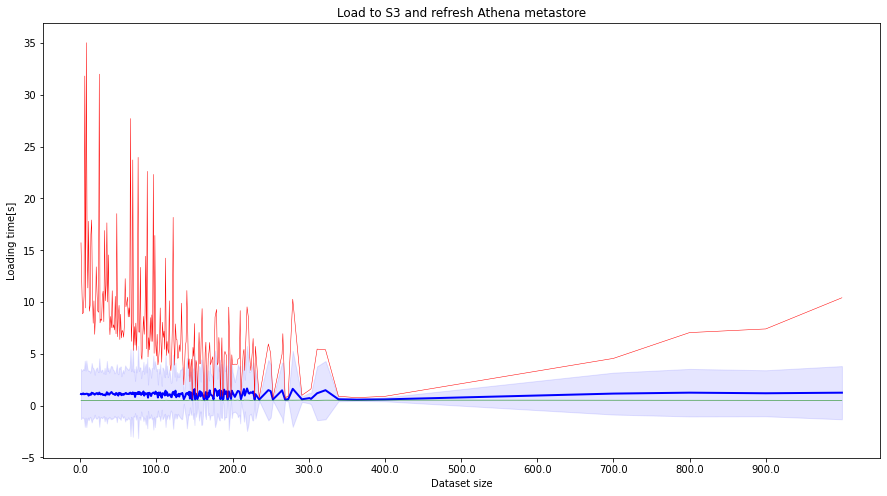

In [14]:
load_group = load_group.loc[:1001]

format_chart(title="Load to S3 and refresh Athena metastore",
             x_label="Dataset size", 
             y_label="Loading time[s]", 
             xticks_range=range(0, 1_000, 100),
             divider=1,
             sufix="")

plt.plot(load_group[("duration", "mean")], linewidth=2, color="b")
plt.plot(load_group[("duration", "min")], linewidth=.5, color="g")
plt.plot(load_group[("duration", "max")], linewidth=.5, color="r")
plt.fill_between(load_group.index, 
                 load_group[("duration", "mean")] - 2*load_group[("duration", "std")],
                 load_group[("duration", "mean")] + 2*load_group[("duration", "std")],
                 color="b", alpha=.1)

In [15]:
read_group = parquet_read.groupby(["Dataset", "dataset_sufix", "rows"]).agg({"duration": "mean"}).reset_index().set_index(["Dataset", "dataset_sufix"])
read_group = read_group.set_index("rows", append=True)
read_group

duration
Dataset                dataset_sufix                                    rows                 
simm_risk_data_eqderiv gzip;['tabledate', 'atomicload'];1509;1230837    1230837    916.837143
                                                                        2461674   1773.987270
                                                                        3692511   2347.428538
                                                                        4923348   3076.064723
                                                                        6154185   4786.851512
                       gzip;['tabledate'];1;1043083                     1043083      4.422771
                                                                        2086166      7.852741
                                                                        3129249      9.984959
                                                                        4172332     12.965214
                                                                        5215415     16.333542
                       snappy;['tabledate', 'atomicload'];1507;10430837 10430837  1013.517608
                                                                        20861674  1662.367075
                                                                        31292511  2422.856758
                                                                        41723348  3951.572846
                       snappy;['tabledate', 'atomicload'];1560;1230837  1230837   1130.143866
                                                                        2461674   1656.275228
                       snappy;['tabledate', 'atomicload'];184;3358100   3358100    130.562718
                                                                        6716200    216.915923
                                                                        10074300   315.673892
                                                                        13432400   410.682457
                                                                        16790500   515.418815
                                                                        20148600   609.537715
                                                                        23506700   722.105343
                       snappy;['tabledate'];1;1043083                   1043083      5.619465
                                                                        2086166      6.255820
                                                                        3129249     22.299490
                                                                        4172332     31.815141
                                                                        5215415     16.776428
                                                                        6258498     16.010954
                                                                        7301581     22.724870
                                                                        8344664     40.976421
                                                                        9387747     22.941534
                                                                        10430830    27.712876
                                                                        11473913    33.242724
                                                                        12516996    39.932888
                                                                        13560079    29.866538
                                                                        14603162    38.698250
                                                                        15646245    51.070998
                       snappy;['tabledate'];1;10430837                  10430837    27.802528
                                                                        20861674    70.014676
                                                                        31292511   107.796668

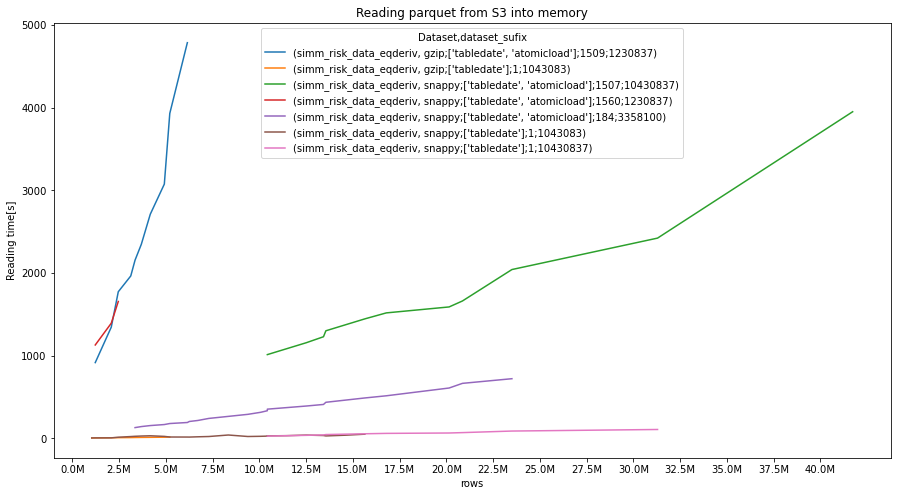

In [16]:
ax = format_chart(title="Reading parquet from S3 into memory",
                  x_label="Dataset size", 
                  y_label="Reading time[s]", 
                  xticks_range=range(0, 40_000_001, 2_500_000))

plot_data = read_group["duration"].unstack(level=[0, 1]).sort_index()
plot_data.interpolate(inplace=True, limit_direction="backward", limit_area="inside")
plot_data.plot(ax=ax)

In [17]:
athena_query["query"] = athena_query.apply(lambda x: x["query"].replace(x["original_sufix"], "sufix"), axis=1)

In [18]:
number_of_data = athena_query[athena_query["query"].str.startswith("SELECT COUNT(*)")][["Dataset", "dataset_sufix", "filename", "example_result"]]
number_of_data["data amount"] = (number_of_data["example_result"]
                                    .str.replace("[{'VarCharValue': '", "", regex=False)
                                    .str.replace("'}]", "", regex=False)
                                    .astype(int))
number_of_data.drop(["example_result"], axis=1, inplace=True)

In [19]:
athena_query = pd.merge(left=athena_query, right=number_of_data, on=["Dataset", "dataset_sufix", "filename"])
athena_query.drop(["filename", "example_result", "original_sufix"], axis=1, inplace=True)

In [20]:
athena_query = pd.merge(left=athena_query, right=stats, on=["Dataset", "dataset_sufix"])
athena_query["iteration"] = athena_query["data amount"] / athena_query["rows"]
athena_query["number of files"] = athena_query["iteration"] * athena_query[("load_id", "max")]
athena_query = athena_query[["Dataset", "dataset_sufix", "query", "duration", "data amount", "number of files", ("compression", "first")]]

In [21]:
athena_query = athena_query.set_index(["query", "Dataset", "dataset_sufix", "data amount"]).sort_index()
athena_query[["duration"]]

duration
query                                              Dataset                dataset_sufix                                    data amount            
SELECT * FROM "simm_poc"."simm_risk_data_eqderi... simm_risk_data_eqderiv gzip;['tabledate', 'atomicload'];1509;1230837    1230837       24.587928
                                                                                                                           2461674       45.857296
                                                                                                                           3692511       60.110301
                                                                                                                           4923348       82.060822
                                                                                                                           6154185      104.324202
                                                                          gzip;['tabledate'];1;1043083                     1043083       19.636517
                                                                                                                           2086166       33.037871
                                                                                                                           3129249       44.998743
                                                                                                                           4172332       65.208468
                                                                                                                           5215415       75.295358
                                                                          snappy;['tabledate', 'atomicload'];1507;10430837 10430837     147.096820
                                                                                                                           20861674     280.389422
                                                                                                                           31292511     380.209165
                                                                                                                           41723348     506.223196
                                                                          snappy;['tabledate', 'atomicload'];1560;1230837  1230837       25.595562
                                                                                                                           2461674       41.394628
                                                                          snappy;['tabledate', 'atomicload'];184;3358100   3358100       55.134611
                                                                                                                           6716200       92.624607
                                                                                                                           10074300     134.537061
                                                                                                                           13432400     171.260848
                                                                                                                           16790500     217.608158
                                                                                                                           20148600     265.697810
                                                                                                                           23506700     315.616813
                                                                          snappy;['tabledate'];1;1043083                   1043083       20.364375
                                                                                                                           2086166       36.278920
                                                                                                                           3129249       48.096165
                      

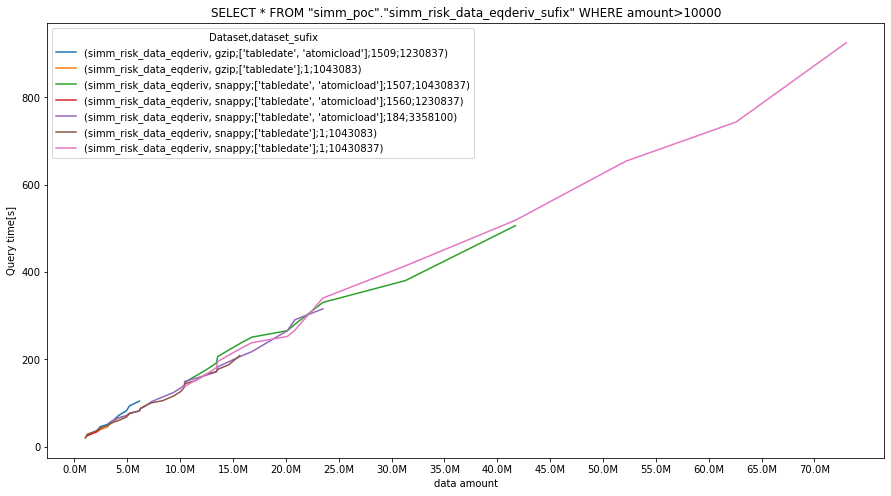

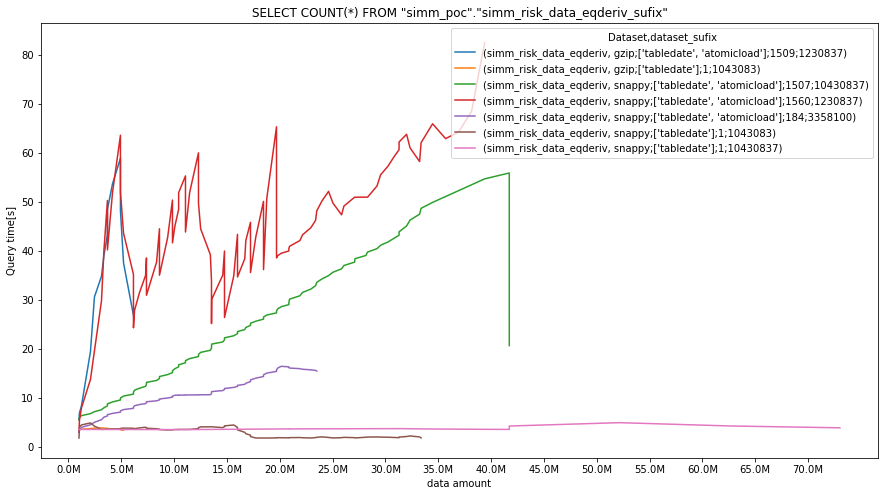

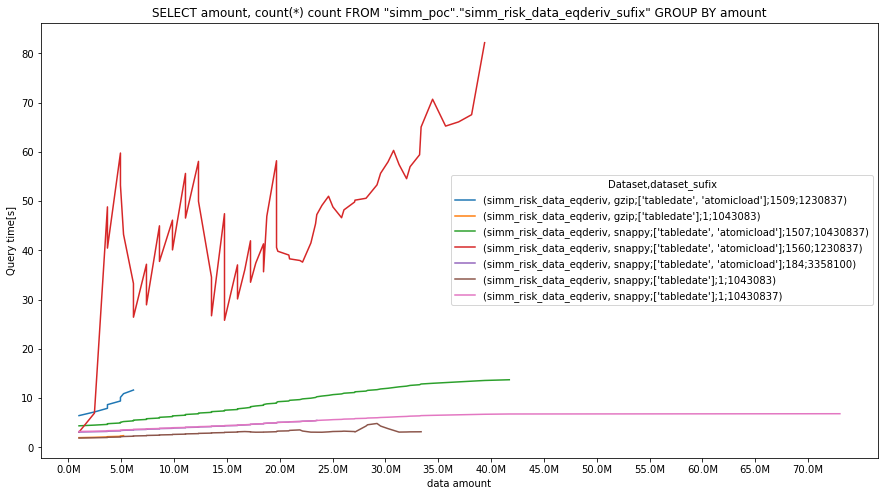

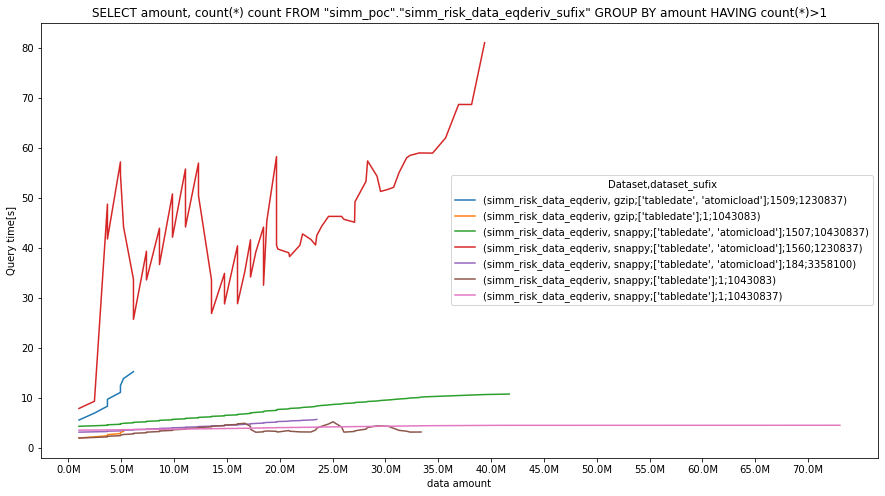

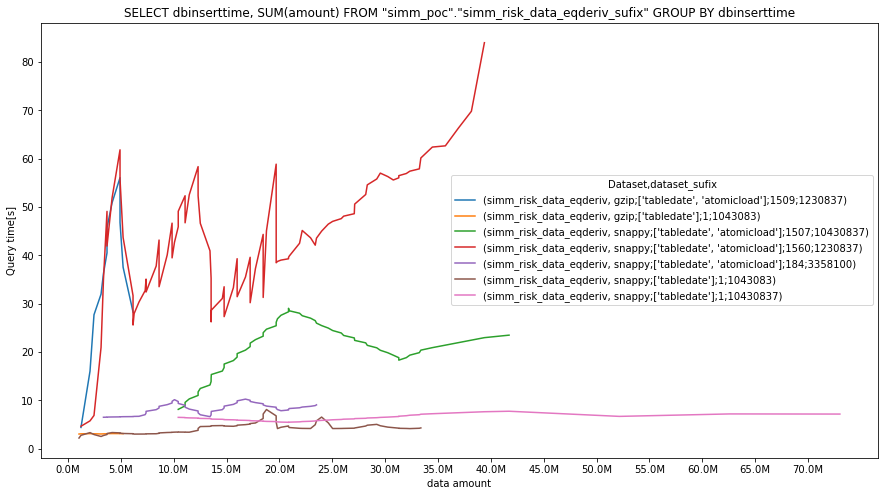

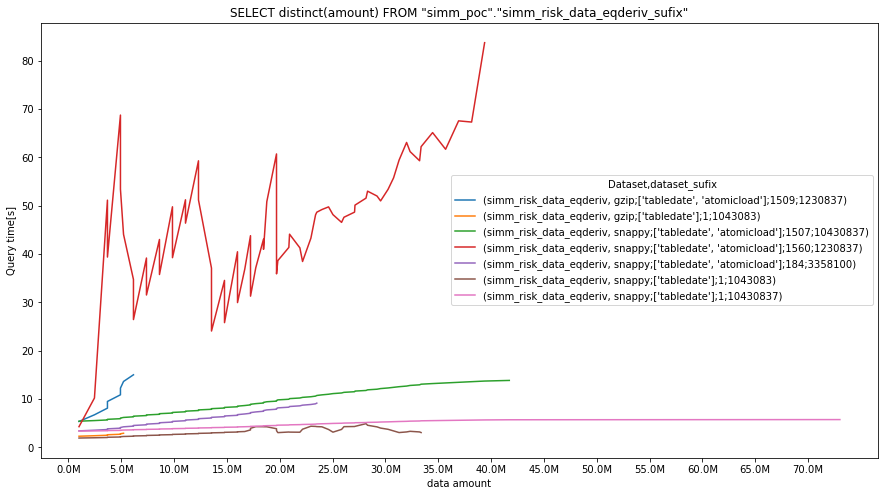

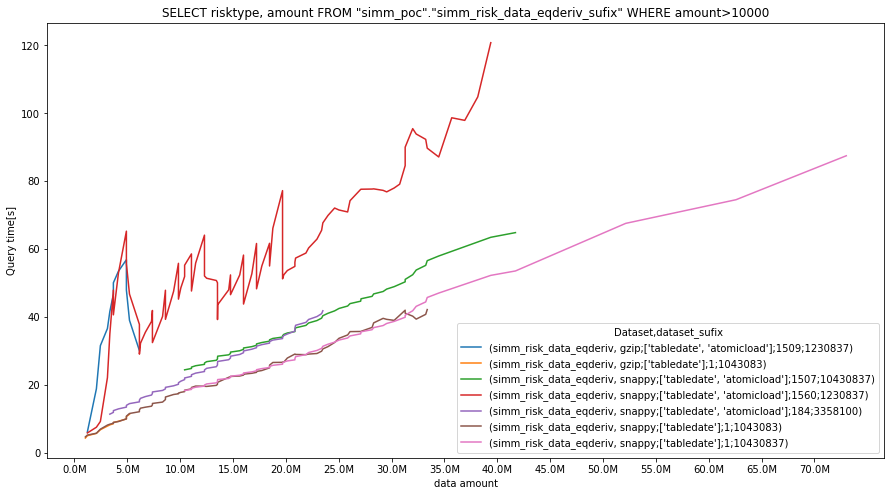

In [22]:
athena_query = athena_query.reset_index().set_index(["Dataset", "dataset_sufix", "data amount"])
for query_type in athena_query["query"].unique():
    ax = format_chart(title=query_type,
                  x_label="Dataset size", 
                  y_label="Query time[s]", 
                  xticks_range=range(0, 70_000_001, 5_000_000))
    
    athena_query_filter = athena_query[athena_query["query"]==query_type]
    
    athena_query_filter = athena_query_filter.reset_index()
    athena_query_filter = athena_query_filter.groupby(["Dataset", "dataset_sufix", "data amount"]).agg({"duration": "mean"})
    plot_data = athena_query_filter["duration"].unstack(level=[0, 1]).sort_index()
    plot_data.interpolate(inplace=True, limit_direction="backward", limit_area="inside")
    plot_data.plot(ax=ax)

In [23]:
athena_query = athena_query.reset_index()
athena_query["rounded data amount"] = athena_query.apply(lambda x: round(x["data amount"], -6) if x["data amount"]<10_000_000 else round(x["data amount"], -7), axis=1)
# athena_query = athena_query.groupby(["query", ("compression", "first"), "rounded data amount", "number of files"]).agg({"duration": "mean"})
athena_query = athena_query.groupby(["query", "rounded data amount", "number of files"]).agg({"duration": "mean"})
athena_query

duration
query                                              rounded data amount number of files            
SELECT * FROM "simm_poc"."simm_risk_data_eqderi... 1000000             1.000000          20.000446
                                                                       1509.000000       24.587928
                                                                       1560.000000       25.595562
                                                   2000000             2.000000          34.658395
                                                                       3018.000000       45.857296
                                                                       3120.000000       41.394628
                                                   3000000             3.000000          46.547454
                                                                       184.000000        55.134611
                                                   4000000             4.000000          62.405336
                                                                       4527.000000       60.110301
                                                   5000000             5.000000          75.549002
                                                                       6036.000000       82.060822
                                                   6000000             6.000000          87.633372
                                                                       7545.000000      104.324202
                                                   7000000             7.000000         100.308940
                                                                       368.000000        92.624607
                                                   8000000             8.000000         105.176523
                                                   9000000             9.000000         115.913491
                                                   10000000            1.000000         137.689416
                                                                       10.000000        136.847073
                                                                       11.000000        151.248365
                                                                       12.000000        166.465194
                                                                       13.000000        176.950649
                                                                       14.000000        187.497926
                                                                       552.000000       134.537061
                                                                       736.000000       171.260848
                                                                       1507.000000      147.096820
                                                   20000000            2.000000         266.801990
                                                                       15.000000        208.499131
                                                                       920.000000       217.608158
                                                                       1104.000000      265.697810
                                                                       1288.000000      315.616813
                                                                       3014.000000      280.389422
                                                   30000000            3.000000         413.946896
                                                                       4521.000000      380.209165
                                                   40000000            4.000000         518.703041
                                                                       6028.000000      506.223196
                                                   50000000            5.000000         653.884335
                                                   60000000            6.000000         743.631782
                               

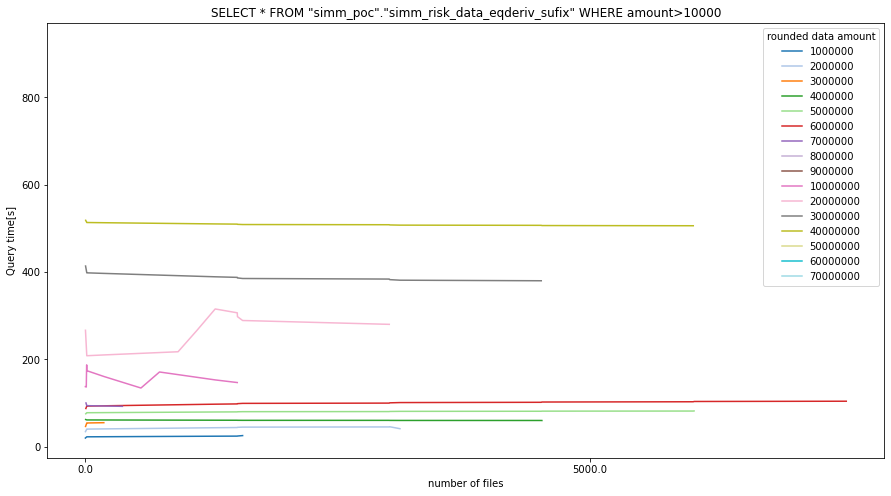

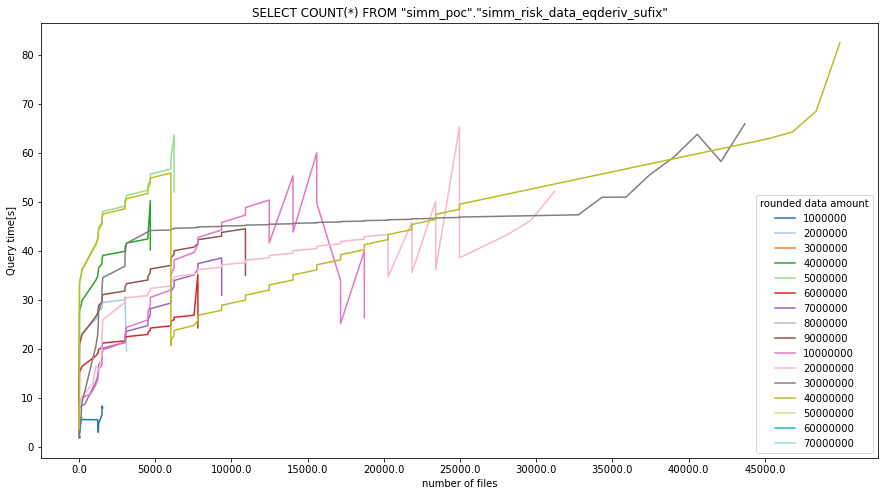

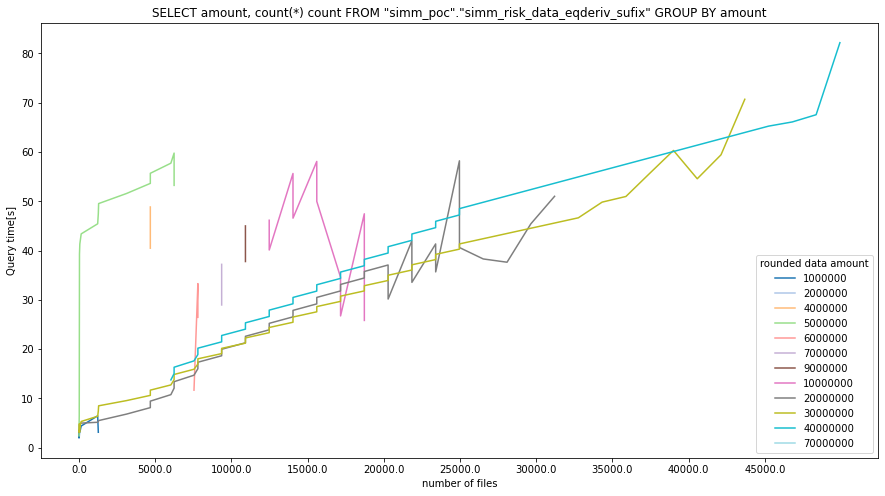

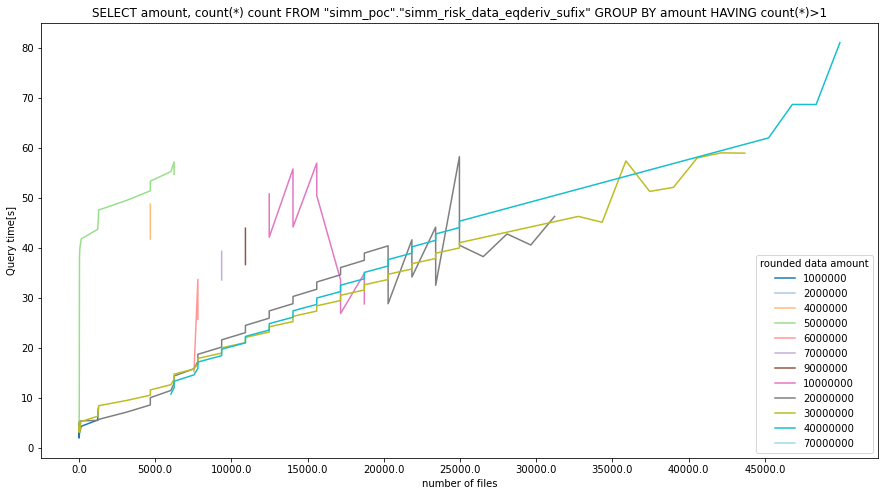

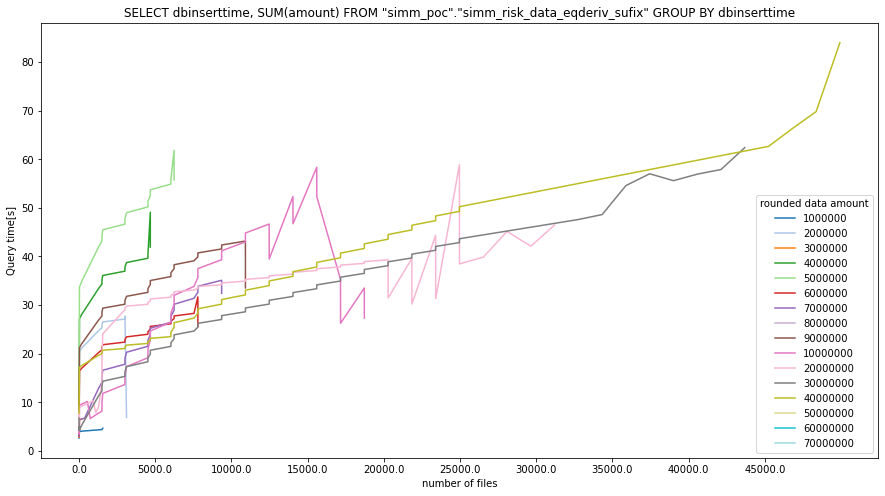

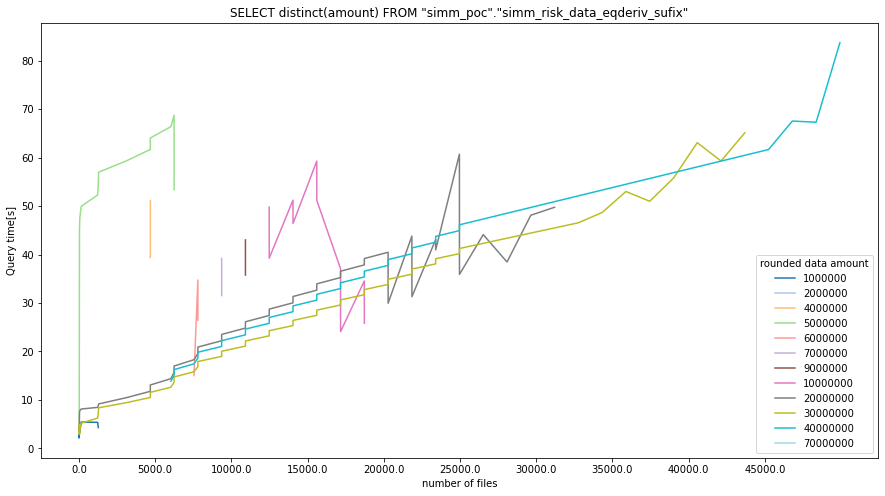

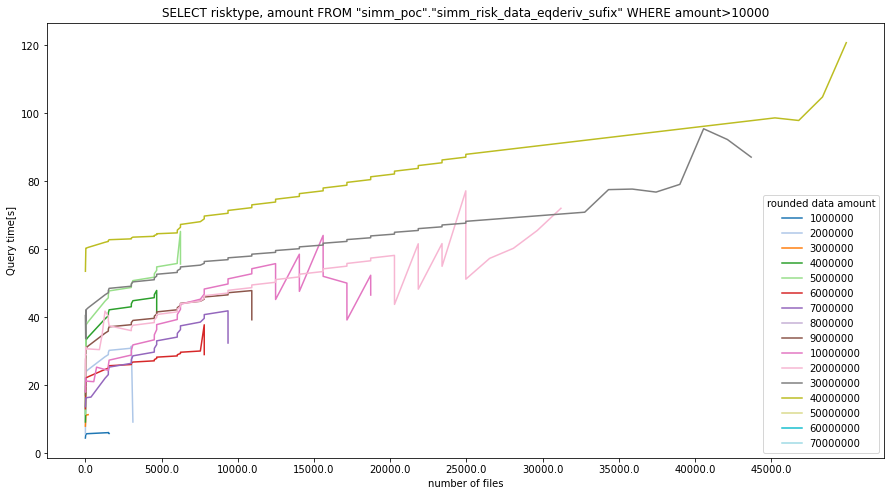

In [26]:
# athena_query = athena_query.reset_index().set_index([("compression", "first"), "rounded data amount", "number of files"])
athena_query = athena_query.reset_index().set_index(["rounded data amount", "number of files"])
for query_type in athena_query["query"].unique():
    ax = format_chart(title=query_type,
                  x_label="Number of files", 
                  y_label="Query time[s]", 
                  xticks_range=range(0, 50_000, 5_000),
                  divider=1,
                  sufix="")
#     ax.set_xscale("log")
    
    athena_query_filter = athena_query[athena_query["query"]==query_type]
    
    plot_data = athena_query_filter["duration"].unstack(level=[0]).sort_index()
    plot_data.interpolate(inplace=True, limit_direction="backward", limit_area="inside")
    plot_data.plot(ax=ax, colormap="tab20")